In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste as pst
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import scipy
import os

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

In [2]:
path_to_output_dir = '../data/Simulation/sparisty_results/'

if not os.path.exists(path_to_output_dir):
    os.makedirs(path_to_output_dir)

Note there will be small variations in sparsity results due to hyperparameters (e.g. pseudocount, alpha, angle of rotation for spatial sim, etc).

# Simulation Functions

In [2]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        # plt.show()

    return new_spots,mapping

def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 40
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

In [3]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X)
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

# Pairwise Simulation

In [4]:
def load_breast_layer(path):
    X = pd.read_csv(path, index_col= 0)
    coor = []
    for c in X.index:
        coor.append([float(x) for x in c.split('x')])
    adata = anndata.AnnData(X = X)
    adata.obsm['spatial'] = np.array(coor)
    return adata

In [5]:
layer1_path = "../data/Stahl-BC/stahl_bc_slice1.csv" 
layer2_path = "../data/Stahl-BC/stahl_bc_slice2.csv"
layer3_path = "../data/Stahl-BC/stahl_bc_slice3.csv"
layer4_path = "../data/Stahl-BC/stahl_bc_slice4.csv"

adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

In [6]:
slices = {
    "SliceA" : adata_layer_1,
    "SliceB" : adata_layer_2,
    "SliceC" : adata_layer_3,
    "SliceD" : adata_layer_4
}

Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.


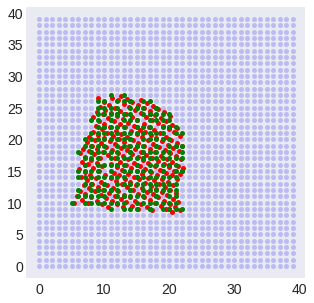

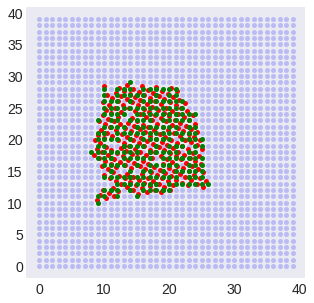

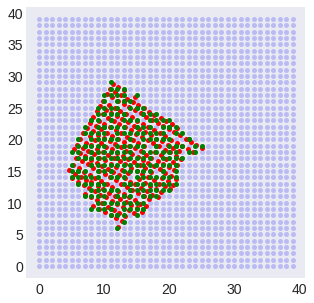

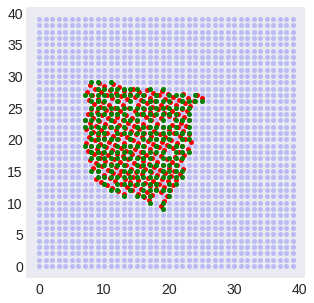

In [17]:
df = pd.DataFrame(index = ['Gene Expression Only', 'Mixed', 'Spatial Only'])
for s, adata_slice in slices.items():
    adata = adata_slice.copy()
    adata_sim_spatial, mappings = simulate_spatial(adata, math.pi/3)
    adata_sim_both = simulate_gene_exp(adata_sim_spatial, pc = 1)
    pi_gex = pst.pairwise_align(adata.copy(), adata_sim_both.copy(), alpha= 0)
    pi_mixed = pst.pairwise_align(adata.copy(), adata_sim_both.copy(), alpha= 0.1)
    pi_spatial = pst.pairwise_align(adata.copy(), adata_sim_both.copy(), alpha= 1)

    df[s] = [np.mean((pi != 0).sum(1)) for pi in [pi_gex, pi_mixed, pi_spatial]]

In [18]:
df.to_csv(path_to_output_dir + 'pairwise_sim_results.csv')

In [19]:
df = pd.read_csv(path_to_output_dir + 'pairwise_sim_results.csv', index_col = 0)
df

,SliceA,SliceB,SliceC,SliceD
Gene Expression Only,1.862205,1.87251,1.856061,1.877863
Mixed,1.862205,1.87251,1.856061,1.877863
Spatial Only,1.862205,1.87251,1.856061,1.877863


# Center Align Simulation

In [36]:
layer1_path = "../data/Stahl-BC/stahl_bc_slice1.csv" 
layer2_path = "../data/Stahl-BC/stahl_bc_slice2.csv"
layer3_path = "../data/Stahl-BC/stahl_bc_slice3.csv"
layer4_path = "../data/Stahl-BC/stahl_bc_slice4.csv"

adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

In [37]:
slices = {
    "SliceA" : adata_layer_1,
    "SliceB" : adata_layer_2,
    "SliceC" : adata_layer_3,
    "SliceD" : adata_layer_4
}

Filtered all slices for common genes. There are 14880 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.283170803695331

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.5991738790939531

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0038464277117453705

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 1.1439363380771894e-05

Filtered all slices for common genes. There are 14043 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14043 common genes.
Filtered all slices for common genes. There are 14043 common genes.
Filtered all slices for common genes. There are 14043 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.3082195986141776

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14043 common genes.
Filtered all slices for common genes. There are 14043 common genes.
Filtered all slices for common genes. There are 14043 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.6052164234780588

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14043 common genes.
Filtered all slices for common genes. There are 14043 common genes.
Filtered all slices for common genes. There are 14043 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0013257865622433584

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14043 common genes.
Filtered all slices for common genes. There are 14043 common genes.
Filtered all slices for common genes. There are 14043 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0004318540721310882

Filtered all slices for common genes. There are 14071 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14071 common genes.
Filtered all slices for common genes. There are 14071 common genes.
Filtered all slices for common genes. There are 14071 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.273097949846171

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14071 common genes.
Filtered all slices for common genes. There are 14071 common genes.
Filtered all slices for common genes. There are 14071 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.644665198335467

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14071 common genes.
Filtered all slices for common genes. There are 14071 common genes.
Filtered all slices for common genes. There are 14071 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0033562349466702557

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14071 common genes.
Filtered all slices for common genes. There are 14071 common genes.
Filtered all slices for common genes. There are 14071 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.00033952346114585197

Filtered all slices for common genes. There are 13981 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 13981 common genes.
Filtered all slices for common genes. There are 13981 common genes.
Filtered all slices for common genes. There are 13981 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 2.1424365731416666

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 13981 common genes.
Filtered all slices for common genes. There are 13981 common genes.
Filtered all slices for common genes. There are 13981 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.6692775903018267

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 13981 common genes.
Filtered all slices for common genes. There are 13981 common genes.
Filtered all slices for common genes. There are 13981 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.001792265590082387

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 13981 common genes.
Filtered all slices for common genes. There are 13981 common genes.
Filtered all slices for common genes. There are 13981 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.00047202645699151446



/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


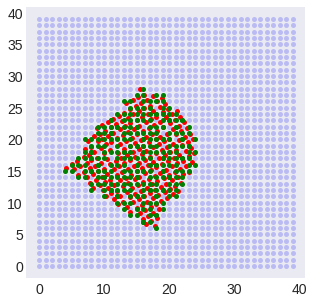

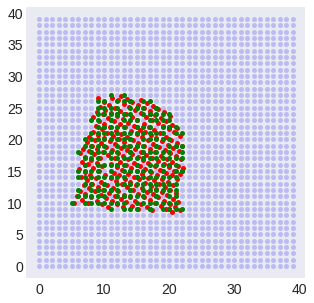

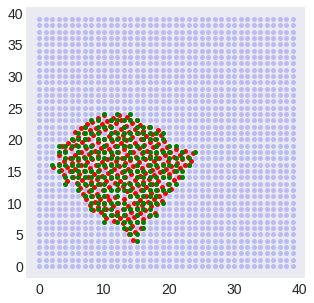

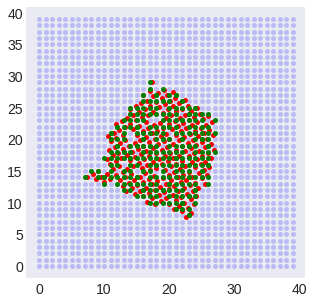

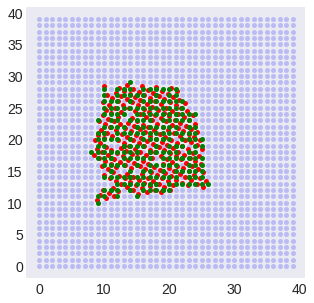

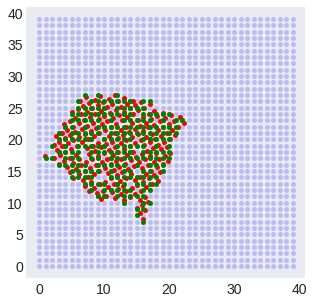

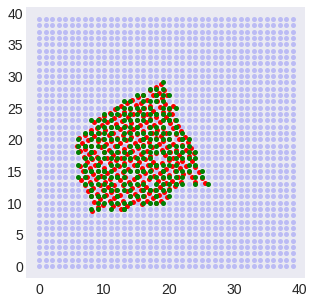

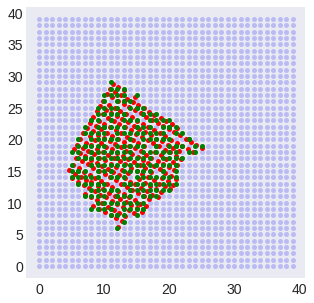

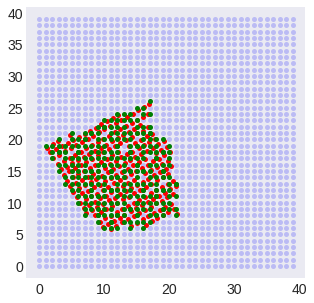

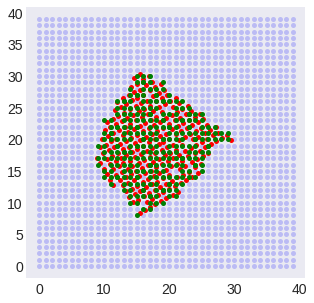

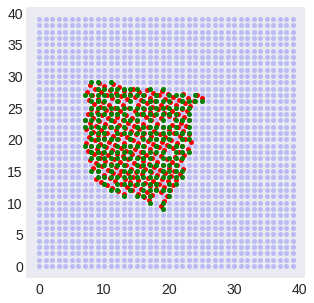

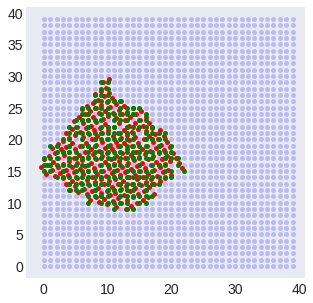

In [38]:
df = pd.DataFrame(index = ['Center, Slice S1', 'Center, Slice S2', 'Center, Slice S3'])
for s, adata_slice in slices.items():
    sim_slices = []
    maps = []
    theta_angles = [math.pi/6, math.pi*2/6, math.pi*4/6]
    for i in range(3):
        adata_sim_spatial, mappings = simulate_spatial(adata_slice, theta_angles[i])
        adata_sim_both = simulate_gene_exp(adata_sim_spatial, pc = 1)
        sim_slices.append(adata_sim_both)
        maps.append(mappings)

    lmbda = len(sim_slices)*[1/len(sim_slices)]
    center_slice, pis = pst.center_align(adata.copy(), sim_slices.copy(), lmbda, alpha = 0.1, n_components= 15)
    df[s] = [np.mean((pi != 0).sum(1)) for pi in pis]

In [42]:
df.to_csv(path_to_output_dir + 'center_sim_results.csv')

In [43]:
df = pd.read_csv(path_to_output_dir + 'center_sim_results.csv', index_col = 0)
df

,SliceA,SliceB,SliceC,SliceD
"Center, Slice S1",1.862205,1.850394,1.901575,1.905512
"Center, Slice S2",1.862205,1.862205,1.889764,1.905512
"Center, Slice S3",1.862205,1.850394,1.901575,1.905512


# Pairwise SCC

We load data from our saved h5ads. See `scc-analysis-pairwise-and-center.ipynb` section 1.

In [14]:
path_to_h5ads = '../data/SCC/cached-results/H5ADs/'

patient_2 = []
patient_5 = []
patient_9 = []
patient_10 = []

patients = {
    "patient_2" : patient_2,
    "patient_5" : patient_5,
    "patient_9" : patient_9,
    "patient_10" : patient_10,
}

for k in patients.keys():
    for i in range(3):
        patients[k].append(sc.read_h5ad(path_to_h5ads + k + '_slice_' + str(i) + '.h5ad'))

In [15]:
df = pd.DataFrame(index = ['Slice A, Slice B', 'Slice B, Slice C'])
for p, patient in patients.items():
    patient_n = patient.copy()
    pi_AB =  pst.pairwise_align(patient_n[0], patient_n[1], alpha = 0.1)
    pi_BC =  pst.pairwise_align(patient_n[1], patient_n[2], alpha = 0.1)
    df[p] = [np.mean((pi != 0).sum(1)) for pi in [pi_AB, pi_BC]]

Filtered all slices for common genes. There are 16133 common genes.
Filtered all slices for common genes. There are 16375 common genes.
Filtered all slices for common genes. There are 15567 common genes.
Filtered all slices for common genes. There are 15684 common genes.
Filtered all slices for common genes. There are 16316 common genes.
Filtered all slices for common genes. There are 16421 common genes.
Filtered all slices for common genes. There are 14520 common genes.
Filtered all slices for common genes. There are 15188 common genes.


In [17]:
df.to_csv(path_to_output_dir + 'pairwise_scc_results.csv')

In [18]:
df = pd.read_csv(path_to_output_dir + 'pairwise_scc_results.csv', index_col = 0)
df

,patient_2,patient_5,patient_9,patient_10
"Slice A, Slice B",1.966967,1.883562,1.919111,2.133945
"Slice B, Slice C",1.987597,1.000000,1.796135,1.741519


# Center SCC 

We load data from our saved h5ads. See `scc-analysis-pairwise-and-center.ipynb` section 1.

In [19]:
patient_2 = []
patient_5 = []
patient_9 = []
patient_10 = []

patients = {
    "patient_2" : patient_2,
    "patient_5" : patient_5,
    "patient_9" : patient_9,
    "patient_10" : patient_10,
}

for k in patients.keys():
    for i in range(3):
        patients[k].append(sc.read_h5ad(path_to_h5ads + k + '_slice_' + str(i) + '.h5ad'))

In [20]:
df = pd.DataFrame(index = ['Center, Slice A', 'Center, Slice B', 'Center, Slice C'])
for p, patient_n in patients.items():
    initial_slice = patient_n[0].copy()
    lmbda = len(patient_n)*[1/len(patient_n)]
    center_slice, pis = pst.center_align(initial_slice, patient_n, lmbda, random_seed = 5)
    df[p] = [np.mean((pi != 0).sum(1)) for pi in pis]

Filtered all slices for common genes. There are 15840 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.9108275340375479

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.017051075059463905

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.003189188288425293

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.002993298948044454

Iteration: 4
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Filtered all slices for common genes. There are 15840 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


R - R_new: 0.0004909843009380799

Filtered all slices for common genes. There are 14922 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14922 common genes.
Filtered all slices for common genes. There are 14922 common genes.
Filtered all slices for common genes. There are 14922 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 1.3644811767973248

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14922 common genes.
Filtered all slices for common genes. There are 14922 common genes.
Filtered all slices for common genes. There are 14922 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.05215976990922533

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 14922 common genes.
Filtered all slices for common genes. There are 14922 common genes.
Filtered all slices for common genes. There are 14922 

In [22]:
df.to_csv(path_to_output_dir + 'center_scc_results.csv')

In [23]:
df = pd.read_csv(path_to_output_dir + 'center_scc_results.csv', index_col = 0)
df

,patient_2,patient_5,patient_9,patient_10
"Center, Slice A",1.000000,1.000000,1.000000,1.000000
"Center, Slice B",1.966967,1.883562,1.919111,2.133945
"Center, Slice C",1.956456,1.883562,1.735111,1.842202
